## Seaborn charting examples

### Load in wholesale data

In [1]:
import pandas as pd
import datetime as dt
import glob
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
#Read in NZ wholesale electricity prices from 2012 to 2021
prices = pd.read_csv('Wholesale_price_trends_20220822204109.csv', \
  header=8)
prices.head(2)

,Period start,Period end,Region ID,Region,Price ($/MWh)
0,01/01/2012,02/01/2012,SFD2201,SFD2201 - Stratford,45.24
1,01/01/2012,02/01/2012,HAY2201,HAY2201 - Haywards,45.06


In [3]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168978 entries, 0 to 168977
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Period start   168978 non-null  object 
 1   Period end     168978 non-null  object 
 2   Region ID      168978 non-null  object 
 3   Region         168978 non-null  object 
 4   Price ($/MWh)  168978 non-null  float64
dtypes: float64(1), object(4)
memory usage: 6.4+ MB


In [5]:
path = './generation_data'
all_files = glob.glob(os.path.join(path, "*.csv"))
df_from_each_file = (pd.read_csv(f, header=8) for f in all_files)
generation = pd.concat(df_from_each_file, ignore_index=True)

generation.head(2)

,Period start,Period end,Region ID,Region,Generation (GWh),Generation ($)
0,01/01/2012,02/01/2012,OTA2202,OTA2202 - Otahuhu,0.000,0.00
1,01/01/2012,02/01/2012,HLY2201,HLY2201 - Huntly,6.955,352716.33


In [6]:
def data_clean(wholesale_df):
  #Convert columns to useful pandas datatypes
  wholesale_df['Period start'] = pd.to_datetime(wholesale_df['Period start'],dayfirst=True )
  wholesale_df['Period end'] = pd.to_datetime(wholesale_df['Period end'],dayfirst=True )
  wholesale_df = wholesale_df.astype({ \
    'Region ID': 'category', \
    'Region': 'category'})
  wholesale_df['day'] = wholesale_df['Period start'].dt.day  
  wholesale_df['week'] = wholesale_df['Period start'].dt.isocalendar().week
  wholesale_df['month'] = wholesale_df['Period start'].dt.month
  wholesale_df['year'] = wholesale_df['Period start'].dt.year  

  return wholesale_df

In [54]:
prices = data_clean(prices)

In [53]:
generation = data_clean(generation)

## Chart wholesale data

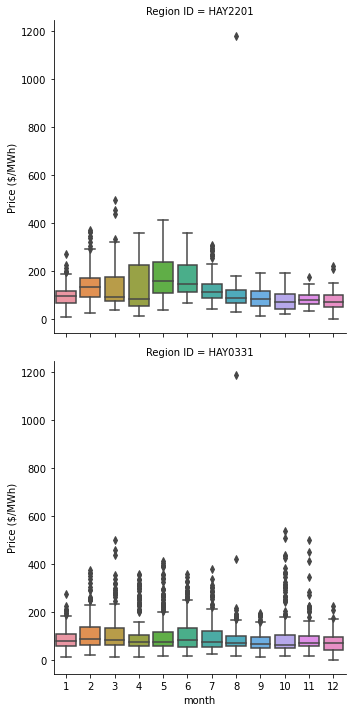

In [18]:
Regions = ['HAY2201', 'HAY0331']

prices['Region ID'].isin(Regions)
data = prices.loc[prices['Region ID'].isin(Regions), :]
# Need to change Region ID back to a sting to prevnt all categories 
# being charted
data = data.astype({'Region ID': 'string'})

sns.catplot(x = 'month', y = 'Price ($/MWh)', \
  kind = 'box', data = data, row ='Region ID')

plt.show()

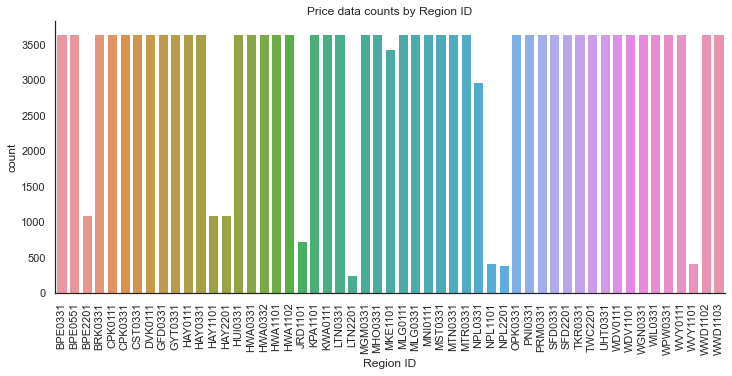

In [47]:
#Lets look at the number of data points for each Region ID
#Some Region ID's contain missing data
sns.set_context('talk')
sns.set_theme(style = 'white', \
  rc = {'figure.figsize': (12 , 5), "axes.spines.right": False, \
    "axes.spines.top": False})
sns.countplot(x='Region ID', data = prices)
plt.xticks(rotation=90)
plt.title('Price data counts by Region ID')
plt.show()

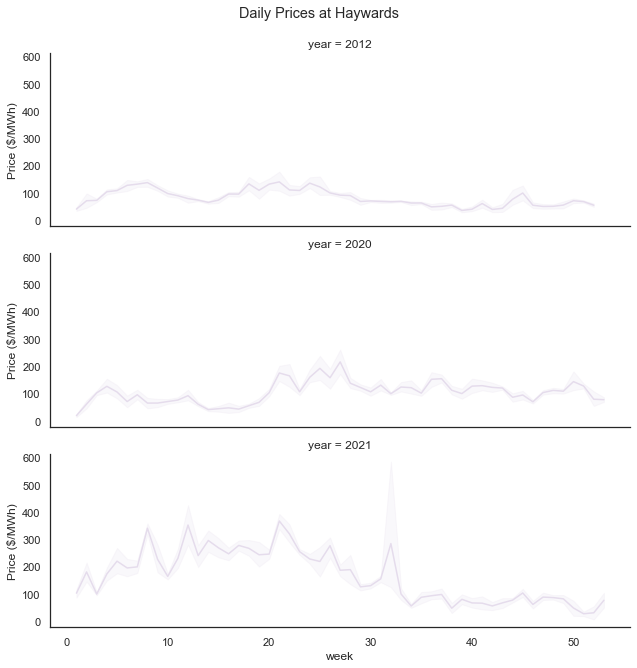

In [52]:
#Lets look at how daily prices at Haywards 2201 varies by year
sns.set_palette('PuRd')

g = sns.relplot(x = 'week', y = 'Price ($/MWh)', \
  kind = 'line', data = prices[prices['Region ID'] == 'HAY2201'], \
    row = 'year', height=3, aspect=3.0)
g.fig.suptitle('Daily Prices at Haywards', y =1.03)

plt.show()